# Libraries

In [ ]:
!pip install pyswarms
!pip install pygad
!pip install deap
!pip install pymoo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import xgboost as xg
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU, Input, Activation
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import random
from random import sample
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
import pygad
from deap import base, creator, tools, algorithms
from deap.benchmarks.tools import hypervolume
from collections import defaultdict
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.indicators.hv import HV
from sklearn.neural_network import MLPClassifier
import os
from sklearn.metrics import r2_score
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
import gc
from sklearn.neural_network import MLPRegressor
import joblib
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# EDA

In [ ]:
# Excel file path in Google Drive
file_path = '/content/drive/MyDrive/Data/DataMoreTargetNSGA.xlsx'
file_path_wo = '/content/drive/MyDrive/Data/DataMoreTargetNSGAwithoutoutlier.xlsx'
# Call the Excel file and save it in a variable
df = pd.read_excel(file_path)
df_wo = pd.read_excel(file_path_wo)
# Definition of headers
columns = ['TC', 'TSF', 'S', 'FX', 'FY', 'DX', 'DY']
# Apply headers to the DataFrame
df = df.drop(df.columns[7:], axis=1)
df.columns = columns
df = df.sample(frac=1).reset_index(drop=True)
# Display the contents of the DataFrame with headers
print(df.head(5))
print(df.tail(5))
# Find the maximum and minimum of each column
column_max = df.max()
column_min = df.min()
print("column_max=")
print(column_max)
print("column_min=")
print(column_min)
# Normalize data in selected columns
df_normalized = (df - column_min) / (column_max - column_min)
# Sort by diameter and then number of steps
#df_normalized = df_normalized.sort_values()
# Display the new normalized DataFrame
print(df_normalized.head(5))
print(df_normalized.tail(5))

    TC  TSF   S       FX       FY        DX        DY
0  1.4  1.5  14  14.1830 -3.06260  0.021981 -0.012462
1  0.8  2.0  10   9.0825 -0.50580  0.023547 -0.016415
2  1.0  2.5  14  21.8290 -4.36270  0.025072 -0.015930
3  0.6  1.5  14   4.3923 -0.96035  0.026005 -0.017442
4  1.4  2.0  20  15.6900 -2.75970  0.023636 -0.014059
      TC  TSF   S      FX       FY        DX        DY
187  0.8  3.0  10  26.428  -2.5018  0.023010 -0.015469
188  1.6  1.5  14  16.811  -2.9833  0.021178 -0.011760
189  1.6  3.5  16  65.948 -12.5910  0.019425 -0.010551
190  1.0  3.0  16  33.945  -7.4200  0.023932 -0.014758
191  1.6  1.5  12  18.960  -3.5438  0.022599 -0.013555
column_max=
TC      1.600000
TSF     4.000000
S      20.000000
FX     85.930000
FY     -0.170630
DX      0.026950
DY     -0.009592
dtype: float64
column_min=
TC      0.600000
TSF     1.500000
S      10.000000
FX      3.476700
FY    -13.440000
DX      0.018292
DY     -0.018650
dtype: float64
    TC  TSF    S        FX        FY        DX        

In [ ]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TC      192 non-null    float64
 1   TSF     192 non-null    float64
 2   S       192 non-null    float64
 3   FX      192 non-null    float64
 4   FY      192 non-null    float64
 5   DX      192 non-null    float64
 6   DY      192 non-null    float64
dtypes: float64(7)
memory usage: 10.6 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TC,192.0,1.100000,0.342458,0.600000,0.800000,1.100000,1.400000,1.600000
TSF,192.0,2.640625,0.833535,1.500000,2.000000,2.500000,3.500000,4.000000
S,192.0,14.437500,3.199517,10.000000,12.000000,14.000000,16.500000,20.000000
FX,192.0,30.883564,21.297644,3.476700,14.135000,25.009500,45.295750,85.930000
FY,192.0,-4.680094,3.176988,-13.440000,-6.623900,-3.928500,-2.262875,-0.170630
DX,192.0,0.023535,0.001894,0.018292,0.022083,0.023749,0.025092,0.026950
DY,192.0,-0.014662,0.002085,-0.018650,-0.016436,-0.014819,-0.012977,-0.009592


In [ ]:
df_normalized.describe().T

,count,mean,std,min,25%,50%,75%,max
TC,192.0,0.500000,0.342458,0.0,0.200000,0.500000,0.800000,1.0
TSF,192.0,0.456250,0.333414,0.0,0.200000,0.400000,0.800000,1.0
S,192.0,0.443750,0.319952,0.0,0.200000,0.400000,0.650000,1.0
FX,192.0,0.332393,0.258299,0.0,0.129265,0.261151,0.507185,1.0
FY,192.0,0.660160,0.239423,0.0,0.513672,0.716801,0.842325,1.0
DX,192.0,0.605549,0.218805,0.0,0.437890,0.630342,0.785401,1.0
DY,192.0,0.440291,0.230130,0.0,0.244452,0.422941,0.626270,1.0


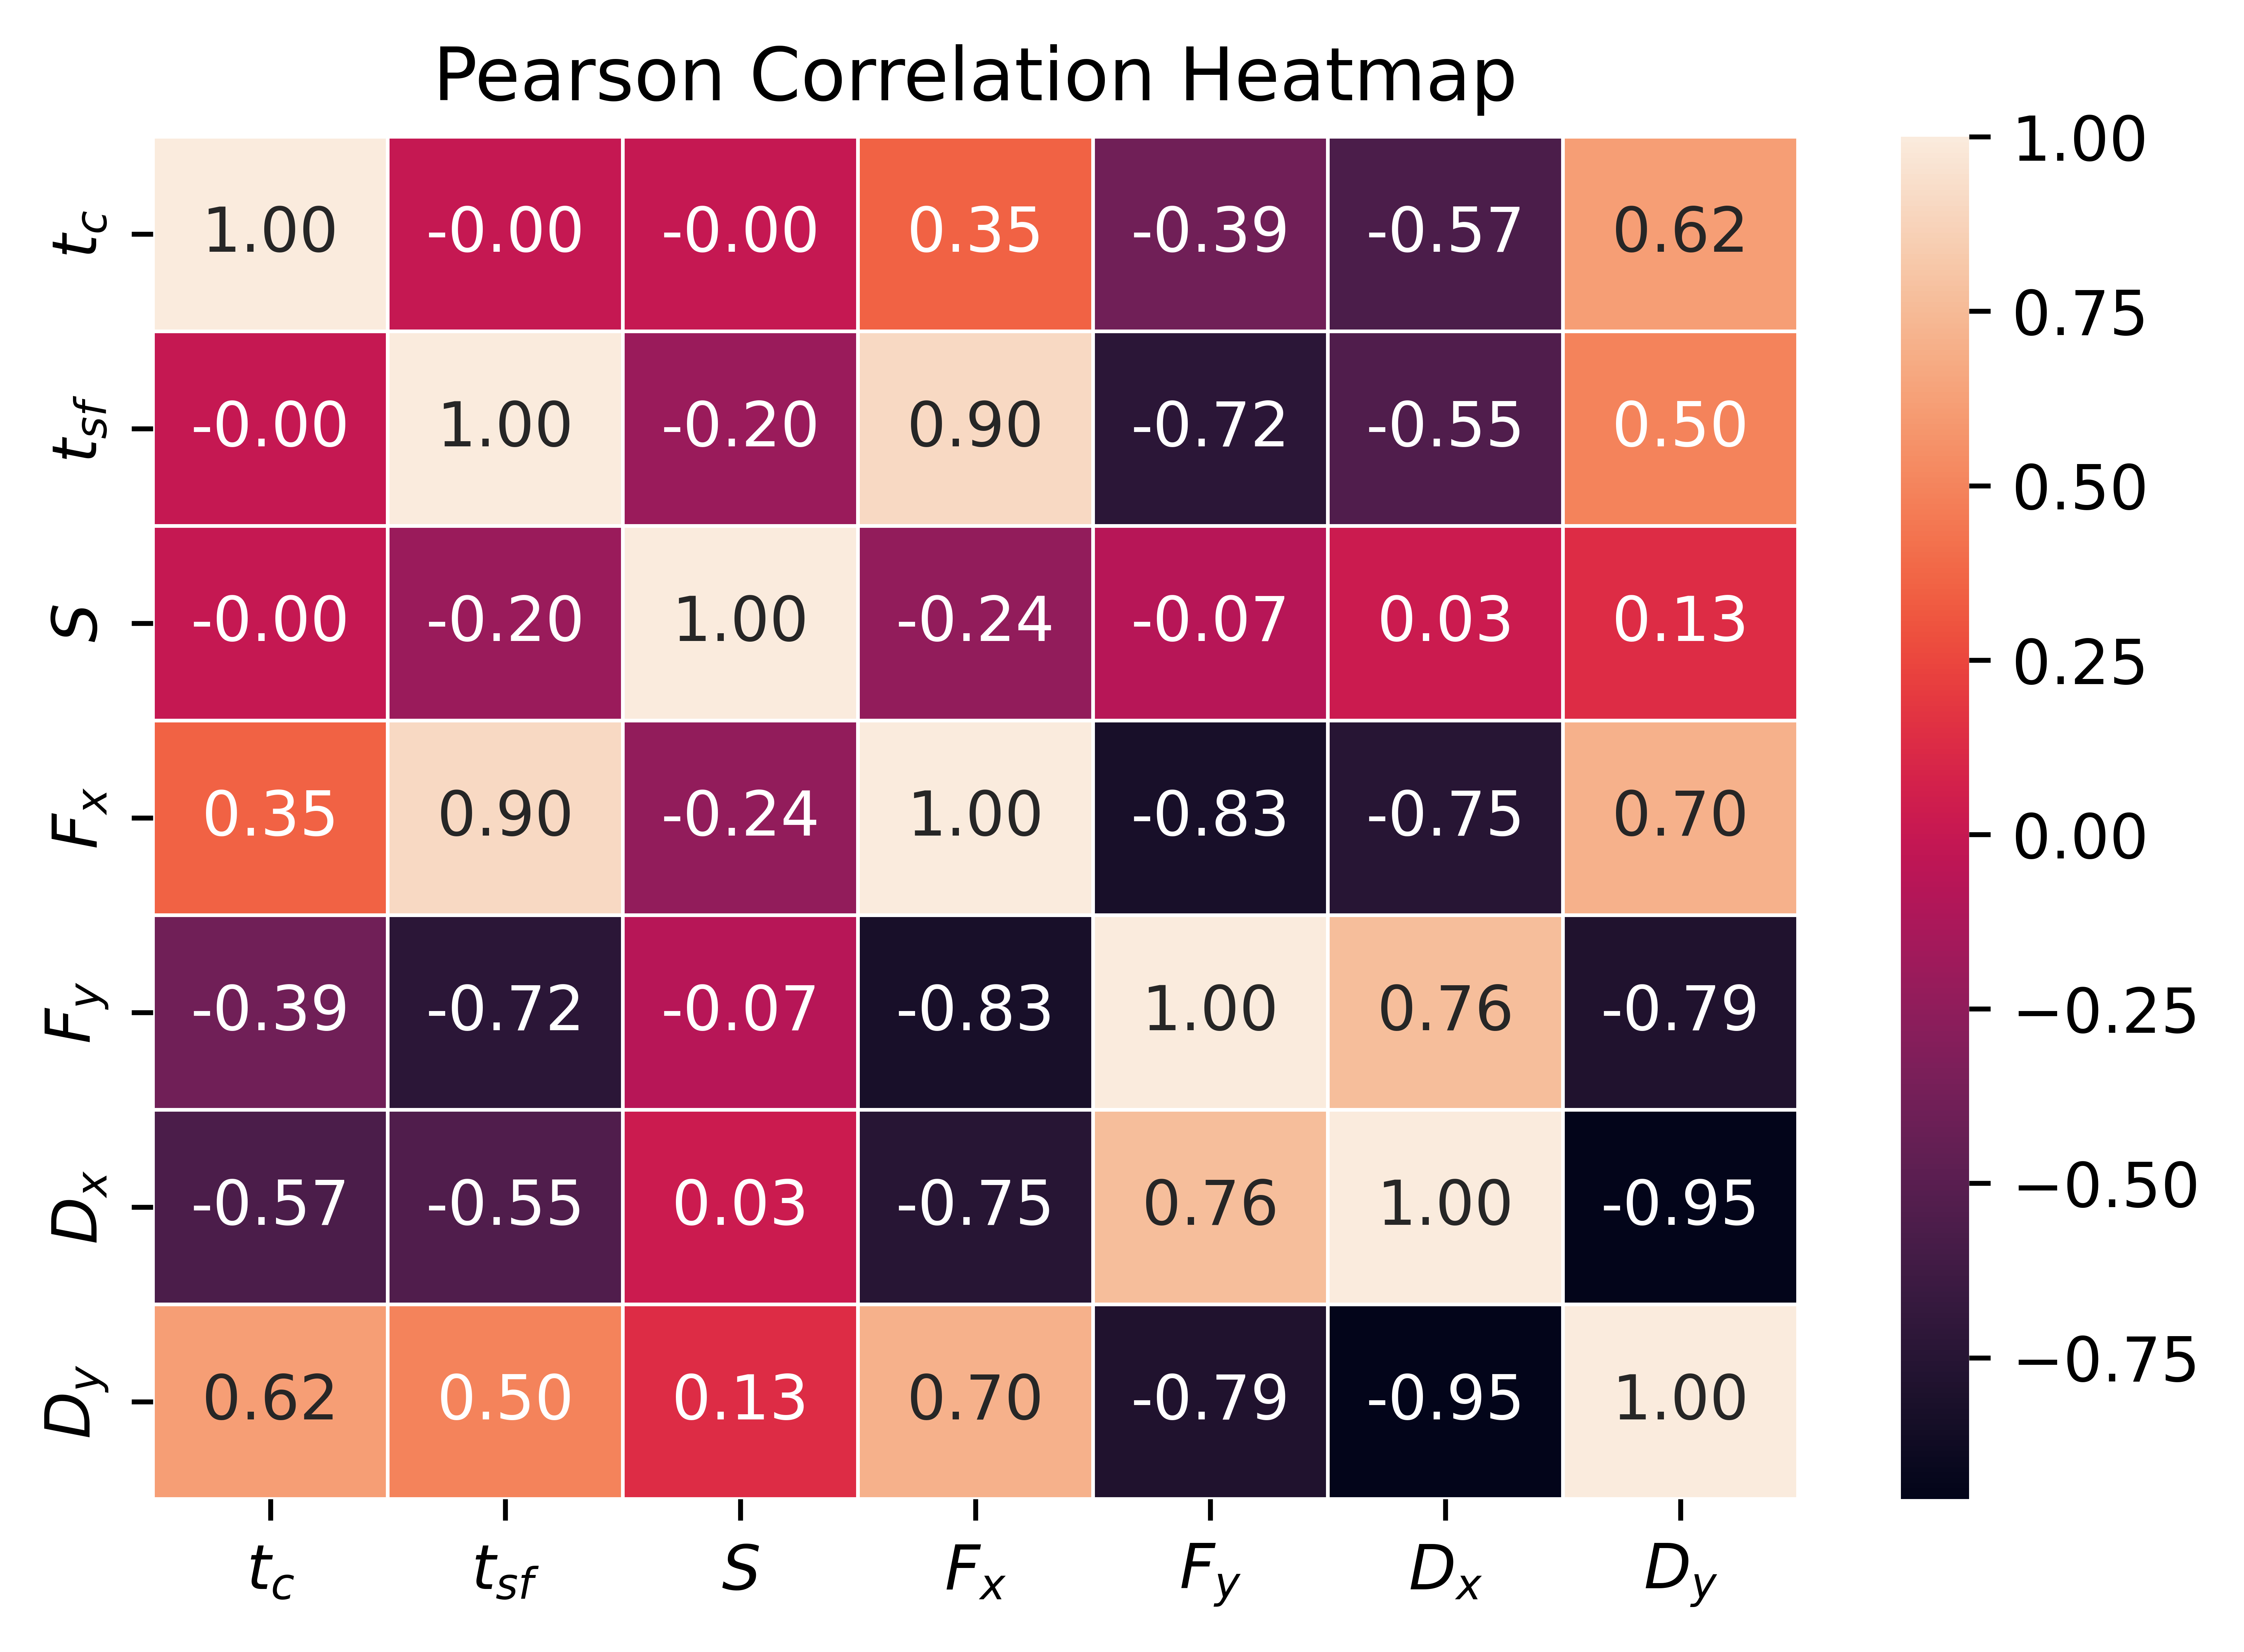

<Figure size 640x480 with 0 Axes>

In [ ]:
corr = abs(df_normalized).corr(method = 'pearson')
plt.figure(figsize=(6,4), dpi =1200)
x_axis_labels = ['$t_{c}$','$t_{sf}$','$S$','$F_{x}$','$F_{y}$','$D_{x}$','$D_{y}$']
y_axis_labels = ['$t_{c}$','$t_{sf}$','$S$','$F_{x}$','$F_{y}$','$D_{x}$','$D_{y}$']
sns.heatmap(corr,annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", linewidth=.5)
plt.title("Pearson Correlation Heatmap")
plt.savefig('Pearson.png', format='png', dpi=1200)
plt.show()
plt.draw()
files.download('Pearson.png')

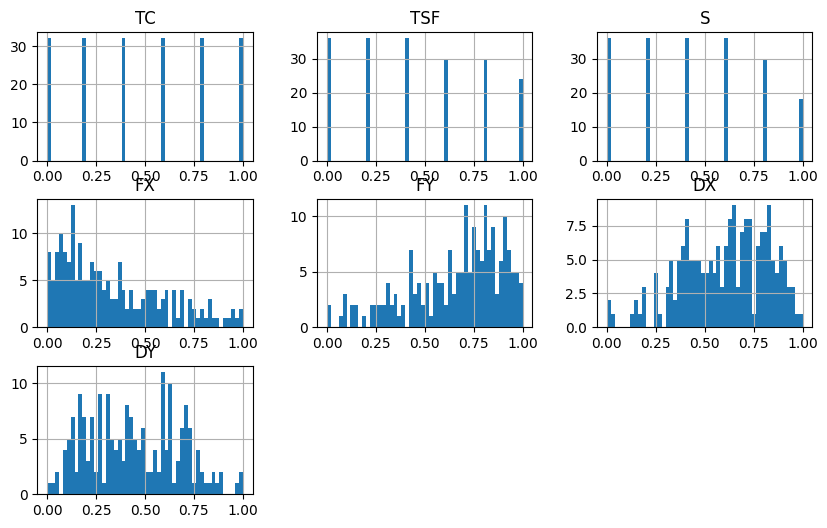

In [ ]:
hist = df_normalized.hist(bins=50, figsize=(10, 6))

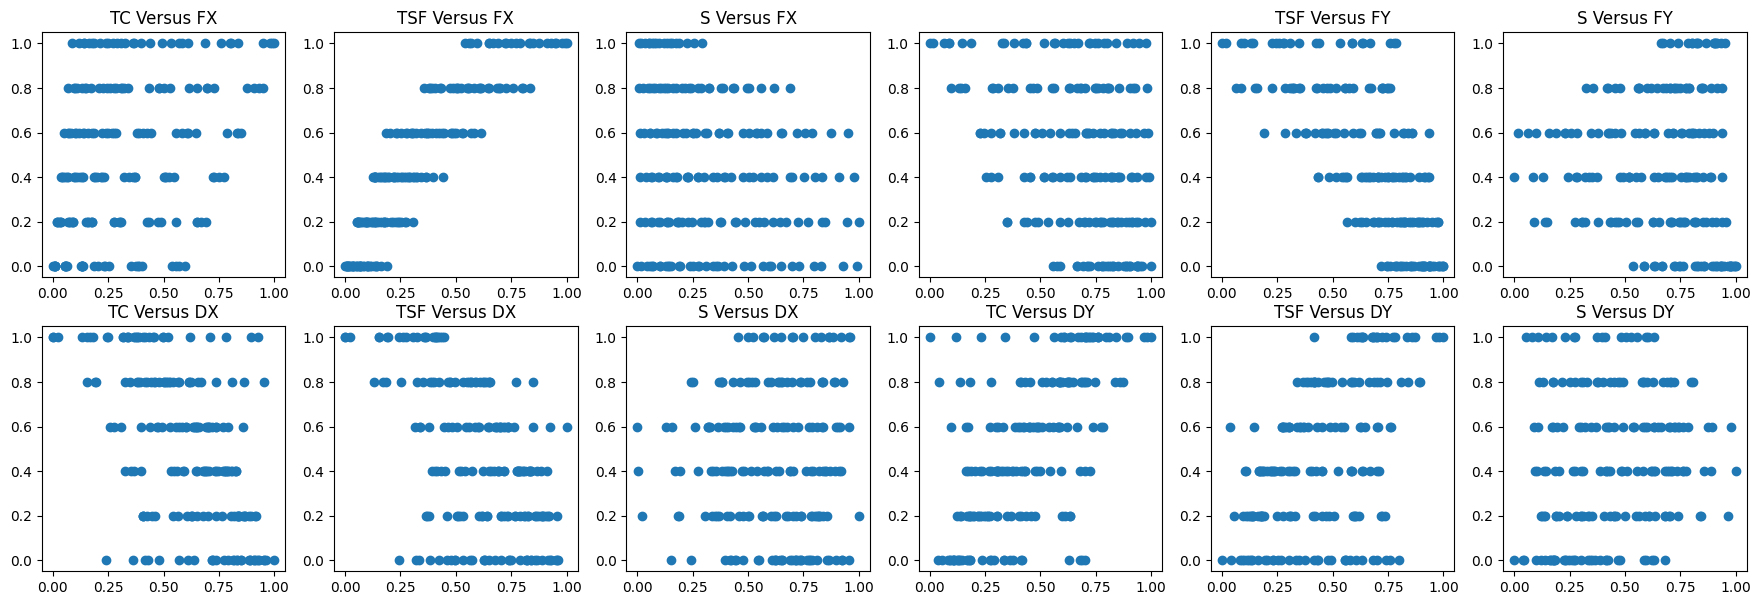

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 7))
ax[0][0].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TC"])
ax[0][0].title.set_text('TC Versus FX')
ax[0][1].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TSF"])
ax[0][1].title.set_text('TSF Versus FX')
ax[0][2].scatter(df_normalized.loc[:,"FX"], df_normalized.loc[:,"S"])
ax[0][2].title.set_text('S Versus FX')
ax[0][3].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TC"])
ax[0][4].title.set_text('TC Versus FY')
ax[0][4].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TSF"])
ax[0][4].title.set_text('TSF Versus FY')
ax[0][5].scatter(df_normalized.loc[:,"FY"], df_normalized.loc[:,"S"])
ax[0][5].title.set_text('S Versus FY')
ax[1][0].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TC"])
ax[1][0].title.set_text('TC Versus DX')
ax[1][1].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TSF"])
ax[1][1].title.set_text('TSF Versus DX')
ax[1][2].scatter(df_normalized.loc[:,"DX"], df_normalized.loc[:,"S"])
ax[1][2].title.set_text('S Versus DX')
ax[1][3].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TC"])
ax[1][3].title.set_text('TC Versus DY')
ax[1][4].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TSF"])
ax[1][4].title.set_text('TSF Versus DY')
ax[1][5].scatter(df_normalized.loc[:,"DY"], df_normalized.loc[:,"S"])
ax[1][5].title.set_text('S Versus DY')
plt.show()

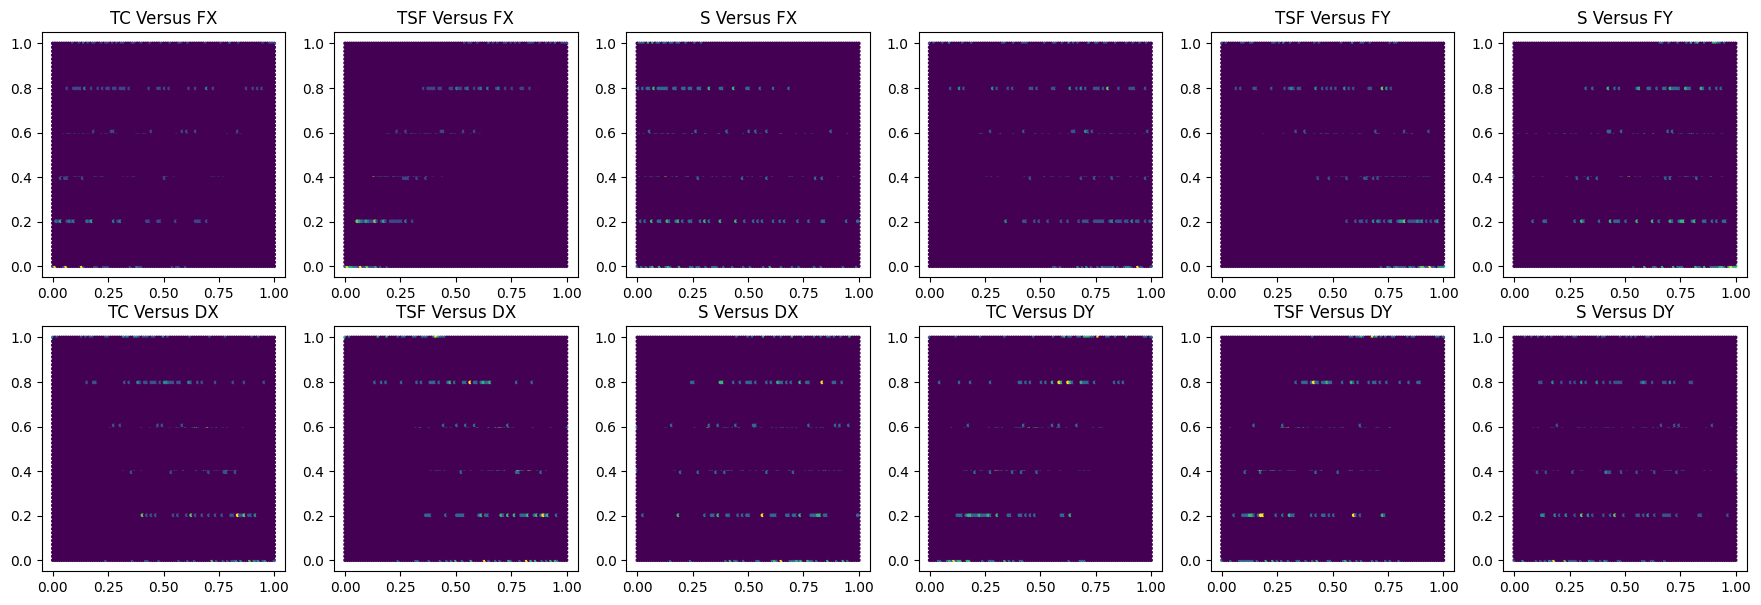

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 7))
ax[0][0].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TC"])
ax[0][0].title.set_text('TC Versus FX')
ax[0][1].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"TSF"])
ax[0][1].title.set_text('TSF Versus FX')
ax[0][2].hexbin(df_normalized.loc[:,"FX"], df_normalized.loc[:,"S"])
ax[0][2].title.set_text('S Versus FX')
ax[0][3].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TC"])
ax[0][4].title.set_text('TC Versus FY')
ax[0][4].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"TSF"])
ax[0][4].title.set_text('TSF Versus FY')
ax[0][5].hexbin(df_normalized.loc[:,"FY"], df_normalized.loc[:,"S"])
ax[0][5].title.set_text('S Versus FY')
ax[1][0].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TC"])
ax[1][0].title.set_text('TC Versus DX')
ax[1][1].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"TSF"])
ax[1][1].title.set_text('TSF Versus DX')
ax[1][2].hexbin(df_normalized.loc[:,"DX"], df_normalized.loc[:,"S"])
ax[1][2].title.set_text('S Versus DX')
ax[1][3].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TC"])
ax[1][3].title.set_text('TC Versus DY')
ax[1][4].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"TSF"])
ax[1][4].title.set_text('TSF Versus DY')
ax[1][5].hexbin(df_normalized.loc[:,"DY"], df_normalized.loc[:,"S"])
ax[1][5].title.set_text('S Versus DY')
plt.show()

In [ ]:
input_data_train_val, x_test_data, target_train_val, y_test_data = train_test_split(df_normalized.iloc[:, 0:3], df_normalized.iloc[:, 3:7], test_size=0.1, random_state=123)
input_data, x_val_data, target, y_val_data = train_test_split(input_data_train_val, target_train_val, test_size=1/9, random_state=123)
input_data = np.array(input_data)
x_test_data = np.array(x_test_data)
target = np.array(target)
y_test_data = np.array(y_test_data)
x_val_data = np.array(x_val_data)
y_val_data = np.array(y_val_data)
input_data_train_val = np.array(input_data_train_val)
target_train_val = np.array(target_train_val)

# Load Model

In [ ]:
regressor = load_model('/content/drive/MyDrive/SavedModels/MLP_modelfinal.h5')

In [ ]:
#predict test with model
predictions = regressor.predict(x_val_data)
predictions.shape

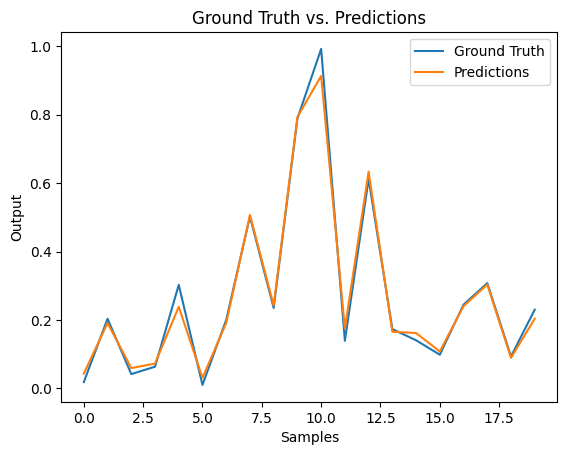

In [ ]:
x = range(len(x_val_data))
plt.plot(x, y_val_data[:,0], label='Ground Truth')
plt.plot(x, predictions[:,0], label='Predictions')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Ground Truth vs. Predictions')
plt.legend()
plt.show()

# NSGA2

In [ ]:
def denorm_nsga(pred_all):
    pred_all_EX = pd.DataFrame(pred_all)
    pred_all_EX.columns =['FX', 'FY', 'DX', 'DY']
    min_pred = df.iloc[:, 3:7].min()
    max_pred = df.iloc[:, 3:7].max()
    denormalized_pred_all = ((pred_all_EX.iloc[:, 0:4])*(max_pred - min_pred)) + min_pred
    d_FX = float(np.array(denormalized_pred_all.iloc[:, 0:1]))
    d_FY = float(np.array(denormalized_pred_all.iloc[:, 1:2]))
    d_DX = float(np.array(denormalized_pred_all.iloc[:, 2:3]))
    d_DY = float(np.array(denormalized_pred_all.iloc[:, 3:4]))
    return d_FX, d_FY, d_DX, d_DY

In [ ]:
class MultiObjectiveMixedVariableProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        vars = {
            "x1": Real(bounds=(0, 1)),
            "x2": Real(bounds=(0, 1)),
            "x3": Real(bounds=(0, 1)),
        }

        super().__init__(vars=vars, n_obj=2, n_ieq_constr=0, **kwargs)

    def _evaluate(self, X, out, *args, **kwargs):
        x1, x2, x3 = X["x1"], X["x2"], X["x3"]
        prediction = regressor.predict(np.array([[x1, x2, x3]]))
        denorm_outputs = denorm_nsga(prediction)

        f1 = -np.sqrt(denorm_outputs[0]**2 + denorm_outputs[1]**2)
        f2 = -np.sqrt(denorm_outputs[2]**2 + denorm_outputs[3]**2)
        out["F"] = [f1, f2]

In [ ]:
problem = MultiObjectiveMixedVariableProblem()

algorithm = MixedVariableGA(pop_size=500,
                            crossover=SBX(prob=0.9, eta=15),
                            mutation=PM(prob=0.1, eta=20),
                            survival=RankAndCrowdingSurvival())

termination = get_termination('n_gen', 50)

res = minimize(problem,
                algorithm,
                termination,
                seed=42)

In [ ]:
x1 = []
x2 = []
x3 = []

for i in range(500):
 x1.append(((list(res.X[i].items())[0][1])*(column_max[0] - column_min[0])) + column_min[0])
 x2.append(((list(res.X[i].items())[1][1])*(column_max[1] - column_min[1])) + column_min[1])
 x3.append(((list(res.X[i].items())[2][1])*(column_max[2] - column_min[2])) + column_min[2])

In [ ]:
res.X

In [ ]:
denorm_x = [x1, x2, x3]
denorm_x

In [ ]:
-res.F

In [ ]:
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1]*100, s=30, marker='.', color='Green')
ax = plt.gca()  # Get the current axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Force (N)', fontsize='12')
plt.ylabel('Tip Displacement (cm)', fontsize='12')
plt.savefig('MLPmainparetofinal1.png', format='png', dpi=1200)
plt.show()
plt.draw()
files.download('MLPmainparetofinal1.png')

In [ ]:
ref_point = np.array([0, 0])
ind = HV(ref_point=ref_point)
print("HV")
ind(res.F)

In [ ]:
F_rand = []
D_rand = []
n_rand = 500

x1_range = [700000, 10000000]
x2_range = [700000, 10000000]
x3_range = [3000, 7000]

input_values = []

for i in range(n_rand):

    X1 = np.random.uniform(x1_range[0], x1_range[1])
    X2 = np.random.uniform(x2_range[0], x2_range[1])
    X3 = np.random.uniform(x3_range[0], x3_range[1])

    input_values.append((X1, X2, X3))

    norm_X1 = (X1 - x1_range[0]) / (x1_range[1] - x1_range[0])
    norm_X2 = (X2 - x2_range[0]) / (x2_range[1] - x2_range[0])
    norm_X3 = (X3 - x3_range[0]) / (x3_range[1] - x3_range[0])

    predicted_outputs = regressor.predict(np.array([norm_X1, norm_X2, norm_X3]).reshape(1, 3))
    denorm_outputs = denorm_nsga(predicted_outputs)

    F_rand.append(np.sqrt(denorm_outputs[0]**2 + denorm_outputs[1]**2))
    D_rand.append(np.sqrt(denorm_outputs[2]**2 + denorm_outputs[3]**2))

for idx, (x1, x2, x3) in enumerate(input_values):
    print(f"Iteration {idx+1}: X1={x1}, X2={x2}, X3={x3}")

In [ ]:
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.figure(figsize=(7, 5))
plt.scatter(F_rand, [i * 100 for i in D_rand], s=30, marker='.', color='blue', label='Experiment data')
plt.scatter(np.sqrt(df_wo.iloc[:,3]**2 + df_wo.iloc[:,4]**2), np.sqrt(df_wo.iloc[:,5]**2 + df_wo.iloc[:,6]**2)*100, s=30, marker='.', color='red', label='Dataset')
plt.scatter(-res.F[:, 0], -res.F[:, 1]*100, s=30, marker='.', color='green', label='Pareto Front' )
ax = plt.gca()
ax.set_ylim([2.1, 3.2])
ax.set_xlim([0, 82])
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(edgecolor='black', prop={'size': 12})
plt.xlabel('Force (N)', fontsize='12')
plt.ylabel('Tip Displacement (cm)', fontsize='12')
plt.savefig('MLPmaindatasetparetofinal.png', format='png', dpi=1200)
plt.show()
plt.draw()
files.download('MLPmaindatasetparetofinal.png')